# Starbucks Capstone Challenge

This is part of Udacity Data Scientist Nanodegree program. Transaction, demographic and offer data are provided to determine which demographic groups respond best to offers.   
    
Provided data contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.    
   

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

today = pd.to_datetime('2021-03-01')

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1. Get to know the data    
In this part, I want to get familiar with three datasets and know what information is included in the datasets.   
#### 1.1 Portfolio 

In [3]:
# to know the size of dataset
portfolio.shape

(10, 6)

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
# to describe the dataset
print(portfolio.info())
print(portfolio.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None
          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000


### 1.2 Profile   

In [6]:
profile.shape

(17000, 5)

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
print(profile.info())
print(profile.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None
                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000


In [9]:
# check ids are unique
profile[profile.id.duplicated()]

,gender,age,id,became_member_on,income


In [10]:
# it appears gender is missing in some users
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [11]:
# check why age = 118, 2175 users 
print(profile[profile.age == 118].shape)
profile[profile.age == 118]

(2175, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [12]:
# users with age = 118 also have missing gender and income
print(profile[profile.age == 118].gender.notnull().sum())
print(profile[profile.age == 118].income.notnull().sum())

0
0


From above, it shows that 2175 users in profile dataset has an age = 118 and they happen all have missing gender and income as well. It's assumed here age = 118 is not the real age. For these subjects, age, gender and income will be imputed during data cleaning step. 

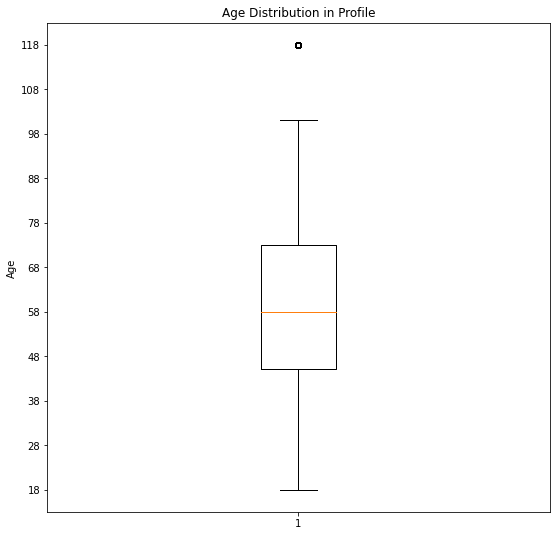

In [13]:
# see age distribution in profile data
plt.figure(figsize = (9, 9))
plt.boxplot(profile.age)
plt.ylabel("Age")
plt.title("Age Distribution in Profile")
plt.yticks(np.arange(min(profile.age), max(profile.age)+1, 10.0))

plt.savefig("figs/age distribution.png")

In [14]:
# how many users age > 80 
print(profile[(profile.age > 80) & (profile.age != 118) ].shape[0])
print(profile[(profile.age > 80) & (profile.age != 118) ].shape[0]/ profile.shape[0])

986
0.058


It appears users older than 80 only take a very small percentage of the users. For the following analysis, users older than 80 will be excluded. 

### 1.3 Transcript

In [15]:
transcript.shape

(306534, 4)

In [16]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [17]:
print(transcript.info())
print(transcript.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000


In [18]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [19]:
# value variable 
transcript[transcript.event == "transaction"].head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [20]:
transcript[transcript.event == "offer received"].head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [21]:
transcript[transcript.event == "offer viewed"].head()

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [22]:
transcript[transcript.event == "offer completed"].head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


From above, the value variable in transcript clearly requires cleaning.

### 2. Data cleaning & preparation
#### 2.1 Portfolio   
Not much cleaning is required on portfolio dataset, just some columns need to be renamed in order to be merged with other datasets.   


In [23]:
portfolio = portfolio.rename(columns={"reward": "offer_reward", "channels": "offer_channels", 
                                      "difficulty": "offer_difficulty", 
                                      "duration": "offer_duration", "id": "offer_id"})

In [24]:
portfolio.head(2)

,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


#### 2.2 Profile   
Based on the understanding above, data cleaning and preparation for profile dataset requires the following: 
- users older then 80 will be excluded from analysis
- age = 118 is not the real age, will needs to be imputed using mean
- missing gender will be imputed using mode
- missing income will be imputed using mean 
- convert 'became_member_on' into date format and create a new variable to calculate how many years a user has been a member

In [25]:
# rename column
profile = profile.rename(columns={"id": "user_id"})

In [26]:
# users older then 118 will be excluded from analysis
profile = profile[(profile['age'] <= 80 ) | (profile['age'] == 118 )]

# age = 118 is not the real age, assign nan
profile['age'].replace(118, np.nan, inplace = True)

# missing age and income will be imputed using mean 
fill_mean = lambda col: col.fillna(col.mean())
col_mean = ['age', 'income']
profile[col_mean] = profile[col_mean].apply(fill_mean, axis=0).copy()

# missing gender will be imputed using mode
profile['gender'].replace('O', np.nan, inplace = True)
mode = profile['gender'].mode()[0]
profile['gender'] = profile['gender'].fillna(mode)

# convert 'became_member_on' into date format and create a new variable to calculate how many years a user has been a member
to_date = lambda x: pd.to_datetime(str(x), format='%Y%m%d')
profile['member_date'] = profile['became_member_on'].apply(to_date)
profile['member_duration'] = (today - profile['member_date']).dt.days / 365.25

# add age groups based on age
profile.loc[(profile.age < 20) , 'age_group'] = 'Under 20'
profile.loc[(profile.age >= 20) & (profile.age < 40) , 'age_group'] = '20-40'
profile.loc[(profile.age >= 40) & (profile.age < 60) , 'age_group'] = '40-60'
profile.loc[(profile.age >= 60) , 'age_group'] = '60-80'

# add income group based on income 
profile.loc[(profile.income >= 30000) & (profile.income < 45000) , 'income_group'] = '30000-45000'
profile.loc[(profile.income >= 45000) & (profile.income < 65000) , 'income_group'] = '45000-65000'
profile.loc[(profile.income >= 65000) & (profile.income < 85000) , 'income_group'] = '65000-85000'
profile.loc[(profile.income >= 85000) & (profile.income < 105000) , 'income_group'] = '85000-105000'
profile.loc[(profile.income >= 105000) & (profile.income <= 120000) , 'income_group'] = '105000-120000'


# drop columns that won't be used
profile = profile.drop(columns = ['member_date', 'became_member_on', 'age'])

In [27]:
profile.head(2)

,gender,user_id,income,member_duration,age_group,income_group
0,M,68be06ca386d4c31939f3a4f0e3dd783,64950.285425,4.046543,40-60,45000-65000
1,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,3.627652,40-60,105000-120000


In [28]:
# confirm all missing data are addressed
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16014 entries, 0 to 16999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           16014 non-null  object 
 1   user_id          16014 non-null  object 
 2   income           16014 non-null  float64
 3   member_duration  16014 non-null  float64
 4   age_group        16014 non-null  object 
 5   income_group     16014 non-null  object 
dtypes: float64(2), object(4)
memory usage: 875.8+ KB


#### 2.3 Transcript   
Data cleaning on transcript focuses on value variable. 

In [29]:
transcript.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [30]:
# rename column
transcript = transcript.rename(columns={"person": "user_id"})

In [31]:
# what's possible value in value variable? 
value_set = set()
for i in transcript['value'] :
    for j in i.keys():
        value_set.add(j)

print(value_set) 

{'offer id', 'offer_id', 'reward', 'amount'}


In [32]:
# expand dictionary in value to columns 
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id'))
transcript['offer id'] = transcript['value'].apply(lambda x: x.get('offer id'))
transcript['reward'] = transcript['value'].apply(lambda x: x.get('reward'))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount'))

In [33]:
# combine 'offer_id' and 'offer id' together
fill_offerid = lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id']
transcript['offer_id'] = transcript.apply(fill_offerid, axis=1)

In [34]:
# fill 0 when reward or amount is missing
transcript['reward'].fillna(0, inplace = True)
transcript['amount'].fillna(0, inplace = True)

In [35]:
# drop value, offer id columns 
transcript = transcript.drop(columns = ['value', 'offer id'])

#### 2.4 Merge three cleaned datasets together     

In [36]:
portfolio_transcript = pd.merge(portfolio, transcript, on='offer_id')
df = pd.merge(portfolio_transcript, profile, on='user_id')

In [37]:
df.head()

,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type,offer_id,user_id,event,time,reward,amount,gender,income,member_duration,age_group,income_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,100000.0,3.474333,60-80,85000-105000
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,100000.0,3.474333,60-80,85000-105000
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,100000.0,3.474333,60-80,85000-105000
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,100000.0,3.474333,60-80,85000-105000
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,100000.0,3.474333,60-80,85000-105000


In [38]:
df.shape

(157503, 16)

### 3. Data analysis & EDA   
Now that data is cleaned and tidy, let's try to find some insights by answering data analysis questions and using EDA.     
#### 3.1 User income distribution 

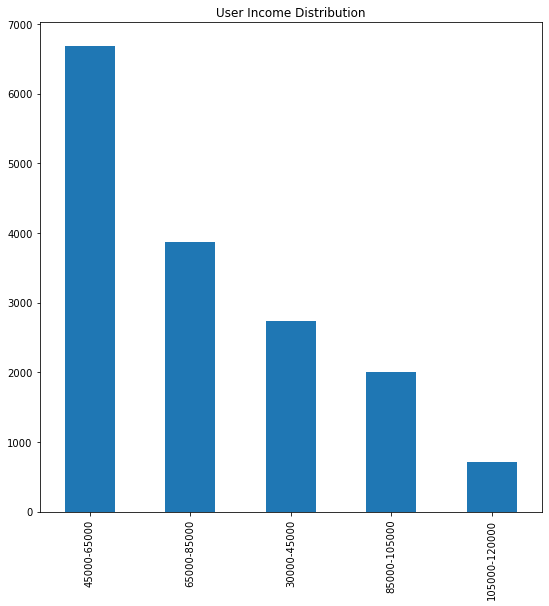

In [39]:
y = df[['user_id', 'income_group']].drop_duplicates()['income_group']
plot = y.value_counts().plot(kind = 'bar', title='User Income Distribution',figsize=(9,9))
fig = plot.get_figure()
fig.savefig("figs/income group distribution.png")


#### 3.2 User age distribution 

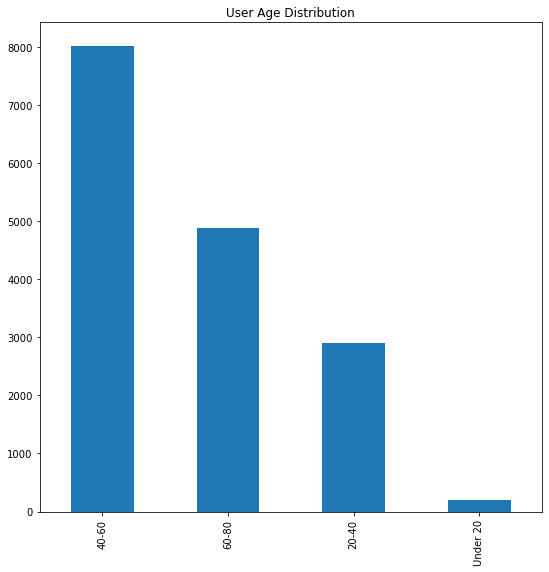

In [40]:
y = df[['user_id', 'age_group']].drop_duplicates()['age_group']
plot = y.value_counts().plot(kind = 'bar', title='User Age Distribution',figsize=(9,9))
fig = plot.get_figure()
fig.savefig("figs/age group distribution.png")

#### 3.3 User gender distribution 

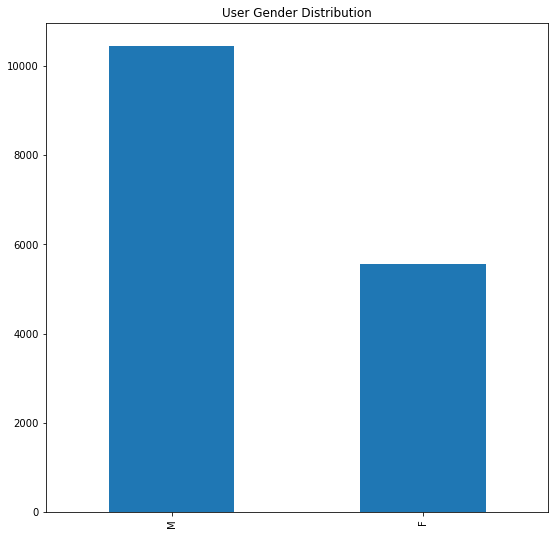

In [41]:
y = df[['user_id', 'gender']].drop_duplicates()['gender']
plot = y.value_counts().plot(kind = 'bar', title='User Gender Distribution',figsize=(9,9))
fig = plot.get_figure()
fig.savefig("figs/gender distribution.png")


#### 3.4 User age distribution by gender

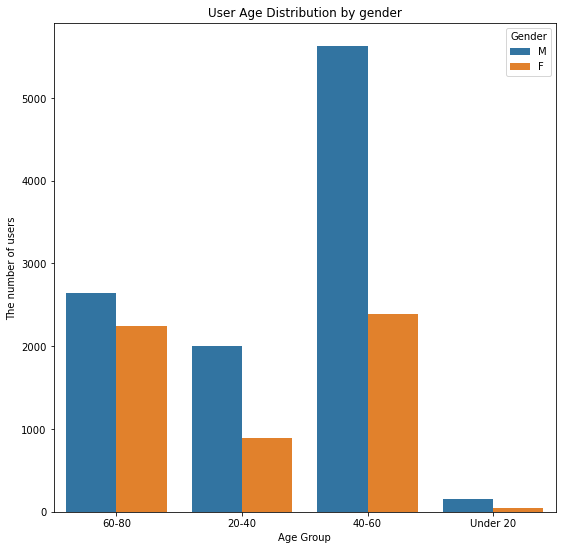

In [42]:
y = df[['user_id', 'age_group', 'gender']].drop_duplicates()[['age_group', 'gender']]
# y.value_counts().plot(kind = 'bar', title='User Age Distribution by gender')
plt.figure(figsize = (9, 9))
sns.countplot(x= "age_group", hue= "gender", data=y)
# sns.set(style="darkgrid")
plt.title('User Age Distribution by gender')
plt.ylabel('The number of users')
plt.xlabel('Age Group')
plt.legend(title='Gender')
plt.savefig("figs/age group distribution by gender.png")

#### 3.5 The count for each type of offer actions 

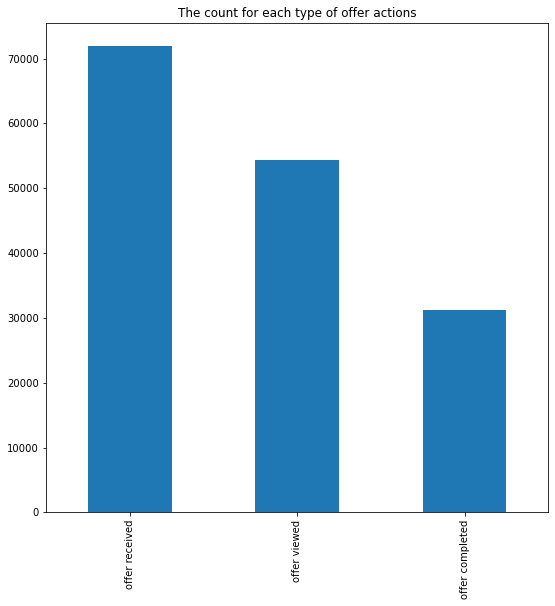

In [43]:
plot = df['event'].value_counts().plot(kind = 'bar', title='The count for each type of offer actions',figsize=(9,9))
fig = plot.get_figure()
fig.savefig("figs/offer actions.png")


#### 3.6 The count for each offer types among completed offers

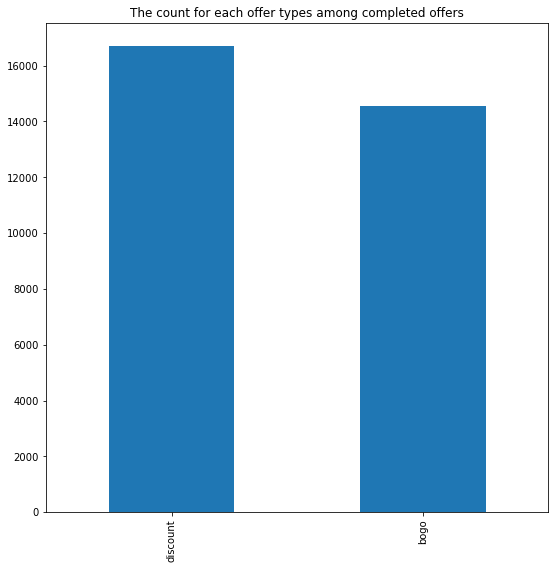

In [44]:
plot = df[df['event']=='offer completed']['offer_type'].value_counts().plot(kind = 'bar', title='The count for each offer types among completed offers',figsize=(9,9))
fig = plot.get_figure()
fig.savefig("figs/completed offer types.png")


#### 3.7 The count for completed offer among income groups, age group, gender, offer types and how much percentage of received offers are completed

In [45]:
def completed_by_received(var):
    t1 = df[df['event']=='offer completed'][var].value_counts()
    t2 = df[df['event']=='offer received'][var].value_counts()
    t1_df = pd.DataFrame(data = zip(t1.index, t1), columns=[var, 'completed_count'])
    t2_df = pd.DataFrame(data = zip(t1.index, t2), columns=[var, 'received_count'])
    t3_df = pd.merge(t1_df, t2_df, on=var)
    t3_df['percentage'] = t3_df['completed_count']/ t3_df['received_count']
    return t3_df

In [46]:
# completed offers by income group, 
# how much percentage of received offers are completed by income group 
print(completed_by_received(var = 'income_group'))

    income_group  completed_count  received_count  percentage
0    45000-65000            10228           30002    0.340911
1    65000-85000             9266           17338    0.534433
2   85000-105000             5527           12318    0.448693
3    30000-45000             4251            9015    0.471547
4  105000-120000             1972            3190    0.618182


In [47]:
# completed offers by age group, 
# how much percentage of received offers are completed by age group 
print(completed_by_received(var = 'age_group'))


  age_group  completed_count  received_count  percentage
0     40-60            14266           35958    0.396741
1     60-80            11263           21917    0.513893
2     20-40             5395           13067    0.412872
3  Under 20              320             921    0.347448


In [48]:
# completed offers by gender, 
# how much percentage of received offers are completed by gender 
print(completed_by_received(var = 'gender'))

  gender  completed_count  received_count  percentage
0      M            17208           46885    0.367026
1      F            14036           24978    0.561935


In [49]:
# completed offers by offer types, 
# how much percentage of received offers are completed by offer types
print(completed_by_received(var = 'offer_type'))

  offer_type  completed_count  received_count  percentage
0   discount            16696           28806    0.579601
1       bogo            14548           28763    0.505789


From above, it appears customers with the follwing characteristics may tend to complete an offer once received:
- with a high income (>105000) 
- age 60-80 
- female 
- offer is discount

### 4. Modeling   
In this part, we will use some common machine learning models to predict whether a customer will complete the offer when recieved. To fulfill this, the data needs to be further cleaned. 

In [50]:
# open up the list in offer_channels 
df = df.drop('offer_channels', 1).join(df.offer_channels.str.join('|').str.get_dummies())
df.head()

,offer_reward,offer_difficulty,offer_duration,offer_type,offer_id,user_id,event,time,reward,amount,gender,income,member_duration,age_group,income_group,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,100000.0,3.474333,60-80,85000-105000,1,1,1,0
1,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,100000.0,3.474333,60-80,85000-105000,1,1,1,0
2,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,100000.0,3.474333,60-80,85000-105000,1,1,1,0
3,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,100000.0,3.474333,60-80,85000-105000,1,1,1,0
4,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,100000.0,3.474333,60-80,85000-105000,1,1,1,0


In [51]:
# subset a dataset where offer is completed, 
# an offer may be completed multiples, but here we remove duplicates 
df_completed = df[df['event']=='offer completed'].drop_duplicates(subset = ['user_id', 'gender', 'income', 
                                                                           'member_duration', 'age_group',
                                                                           'income_group','offer_type', 
                                                                            'offer_reward', 'offer_difficulty',
                                                                           'offer_duration', 'offer_id', 'event', 
                                                                           'email', 'mobile', 'social', 'web'
                                                                           ])
df_completed['y_completed'] = 1 

In [52]:
df_completed.columns

Index(['offer_reward', 'offer_difficulty', 'offer_duration', 'offer_type',
       'offer_id', 'user_id', 'event', 'time', 'reward', 'amount', 'gender',
       'income', 'member_duration', 'age_group', 'income_group', 'email',
       'mobile', 'social', 'web', 'y_completed'],
      dtype='object')

In [53]:
# subset a dataset where offer is received,
# here we exclude informational offer 
df_received = df[(df['event']=='offer received') & (df['offer_type']!='informational')].drop_duplicates(subset = ['user_id', 'gender', 'income', 
                                                                           'member_duration', 'age_group',
                                                                           'income_group','offer_type', 
                                                                            'offer_reward', 'offer_difficulty',
                                                                           'offer_duration', 'offer_id', 'event', 
                                                                           'email', 'mobile', 'social', 'web'
                                                                                                                 ])
df_received['y'] = 0
df_received = df_received[['y',
                           'user_id', 'gender', 'income', 
                            'member_duration', 'age_group',
                            'income_group','offer_type', 
                            'offer_reward', 'offer_difficulty',
                            'offer_duration', 'offer_id', 'event', 
                            'email', 'mobile', 'social', 'web'
                          ]]
df_received.head()

,y,user_id,gender,income,member_duration,age_group,income_group,offer_type,offer_reward,offer_difficulty,offer_duration,offer_id,event,email,mobile,social,web
0,0,4b0da7e80e5945209a1fdddfe813dbe0,M,100000.0,3.474333,60-80,85000-105000,bogo,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,offer received,1,1,1,0
7,0,4b0da7e80e5945209a1fdddfe813dbe0,M,100000.0,3.474333,60-80,85000-105000,discount,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,1,0,0,1
12,0,1e9420836d554513ab90eba98552d0a9,M,70000.0,3.430527,20-40,65000-85000,bogo,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,offer received,1,1,1,0
14,0,1e9420836d554513ab90eba98552d0a9,M,70000.0,3.430527,20-40,65000-85000,bogo,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,1,1,1,1
22,0,1e9420836d554513ab90eba98552d0a9,M,70000.0,3.430527,20-40,65000-85000,discount,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,1,0,0,1


In [54]:
# merge df_completed and df_received together, 
# if a record is in df_completed then it's completed,
# if a record is bot in df_completed but in df_received
# then it's not completed
df_merge = df_received.merge(df_completed, how = 'left', on = ['user_id', 'gender', 'income', 
                                                                'member_duration', 'age_group',
                                                                'income_group','offer_type', 
                                                                 'offer_reward', 'offer_difficulty',
                                                                 'offer_duration', 'offer_id', 
                                                                 'email', 'mobile', 'social', 'web'
])

In [55]:
label_y = lambda x: x['y'] if np.isnan(x['y_completed'])  else x['y_completed']
df_merge['y'] = df_merge.apply(label_y, axis=1)




In [56]:
df_received.shape, df_completed.shape, df_merge.shape

((47742, 17), (26989, 20), (47742, 22))

In [57]:
# drop some columns that won't be used in modeling
df_merge = df_merge.drop(columns = ['income_group', 'event_x', 'event_y', 'time', 'reward', 'amount', 'y_completed'])

In [58]:
# more cleaning to do 
# one hot code categorical variables, 
# including 'gender', 'age_group', 'offer_type', 'offer_id'
df_merge = pd.get_dummies(df_merge, columns = ['gender', 'age_group', 'offer_type', 'offer_id'])

In [59]:
# normalize numerical variables,
# including 'income', 'member_duration', 'offer_reward', 'offer_difficulty'
# 'offer_duration'
scaler = MinMaxScaler() 
num_var = ['income', 'member_duration', 'offer_reward', 'offer_difficulty', 'offer_duration']
df_merge[num_var] = scaler.fit_transform(df_merge[num_var])

In [60]:
df_merge = df_merge.drop(columns = 'user_id')

In [61]:
df_merge.head()

,y,income,member_duration,offer_reward,offer_difficulty,offer_duration,email,mobile,social,web,...,offer_type_bogo,offer_type_discount,offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2,offer_id_2906b810c7d4411798c6938adc9daaa5,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4
0,1.0,0.777778,0.175535,1.000,0.333333,0.4,1,1,1,0,...,1,0,0,0,0,0,0,1,0,0
1,1.0,0.777778,0.175535,0.375,1.000000,1.0,1,0,0,1,...,0,1,1,0,0,0,0,0,0,0
2,0.0,0.444444,0.166758,1.000,0.333333,0.4,1,1,1,0,...,1,0,0,0,0,0,0,1,0,0
3,1.0,0.444444,0.166758,1.000,0.333333,0.0,1,1,1,1,...,1,0,0,0,0,1,0,0,0,0
4,1.0,0.444444,0.166758,0.375,1.000000,1.0,1,0,0,1,...,0,1,1,0,0,0,0,0,0,0


In [62]:
df_merge.columns

Index(['y', 'income', 'member_duration', 'offer_reward', 'offer_difficulty',
       'offer_duration', 'email', 'mobile', 'social', 'web', 'gender_F',
       'gender_M', 'age_group_20-40', 'age_group_40-60', 'age_group_60-80',
       'age_group_Under 20', 'offer_type_bogo', 'offer_type_discount',
       'offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offer_id_2906b810c7d4411798c6938adc9daaa5',
       'offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offer_id_ae264e3637204a6fb9bb56bc8210ddfd',
       'offer_id_f19421c1d4aa40978ebb69ca19b0e20d',
       'offer_id_fafdcd668e3743c1bb461111dcafc2a4'],
      dtype='object')

In [63]:
# split test and train datasets
X = df_merge.drop(columns = 'y')
y = df_merge['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [64]:
def model_metrics(model, y_train_predict, y_test_predict):
    m1_train_accuracy = accuracy_score(y_train, y_train_predict)
    m1_train_f1score = f1_score(y_train, y_train_predict)
    m1_test_accuracy = accuracy_score(y_test, y_test_predict)
    m1_test_f1score = f1_score(y_test, y_test_predict)
    print('{} accuracy score, train: {}, test: {}'.format(model, m1_train_accuracy, m1_test_accuracy ) )
    print('{} f1 score, train: {}, test: {}'.format(model, m1_train_f1score , m1_test_f1score ) )

In [65]:
# Model 1 - Naive predictor - benchmark

y_train_predict = np.ones(len(y_train))
y_test_predict = np.ones(len(y_test))
#m1_train_accuracy = accuracy_score(y_train, y_train_predict)
#m1_train_f1score = f1_score(y_train, y_train_predict)
#m1_test_accuracy = accuracy_score(y_test, y_test_predict)
#m1_test_f1score = f1_score(y_test, y_test_predict)

#print('Naive predictor accuracy score, train: {}, test: {}'.format(m1_train_accuracy, m1_test_accuracy ) )
#print('Naive predictor f1 score, train: {}, test: {}'.format( m1_train_f1score , m1_test_f1score ) )

model_metrics('Naive predictor', y_train_predict, y_test_predict)

Naive predictor accuracy score, train: 0.5657859301594901, test: 0.5641974446694128
Naive predictor f1 score, train: 0.7226861849523191, test: 0.7213890376718443


In [66]:
# Model 2 - Logistic regression model 
model2 = LogisticRegression(random_state=42)
model2.fit(X_train, y_train)
y_train_predict = model2.predict(X_train)
y_test_predict = model2.predict(X_test)

model_metrics('Logistic regression model', y_train_predict, y_test_predict)

Logistic regression model accuracy score, train: 0.6890690924324486, test: 0.6867974586329679
Logistic regression model f1 score, train: 0.733543605918404, test: 0.7312162971839424


In [67]:
# model 3 - Random forest model
model3 = RandomForestClassifier(random_state=42)
model3.fit(X_train, y_train)
y_train_predict = model3.predict(X_train)
y_test_predict = model3.predict(X_test)

model_metrics('Random forest model', y_train_predict, y_test_predict)

Random forest model accuracy score, train: 0.9917113019539783, test: 0.6982475738322977
Random forest model f1 score, train: 0.9926597238784217, test: 0.7374240583232078


In [68]:
# model 4 - Gradient boosting model 
model4 = GradientBoostingClassifier(random_state=42)
model4.fit(X_train, y_train)
y_train_predict = model4.predict(X_train)
y_test_predict = model4.predict(X_test)

model_metrics('Gradient boosting model', y_train_predict, y_test_predict)


Gradient boosting model accuracy score, train: 0.7491546724916963, test: 0.7424422257906863
Gradient boosting model f1 score, train: 0.7841935899086112, test: 0.7786112944847865


In [69]:
# model 5 - Decision tree model 
model5 = DecisionTreeClassifier(random_state=42)
model5.fit(X_train, y_train)
y_train_predict = model5.predict(X_train)
y_test_predict = model5.predict(X_test)

model_metrics('Decision tree model', y_train_predict, y_test_predict)


Decision tree model accuracy score, train: 0.9918309943445346, test: 0.6839349298331355
Decision tree model f1 score, train: 0.9927325968321576, test: 0.7185226636821487


### 5. Conclusion & next steps 

Based on the evaluation of metrics from the five models above, it appears the graient boosting model is the most suitable among five models, with a test f1 score 0.78 and test accuracy score 0.74. Logistic regression, random forest, decision tree all have better performance than the benchmark model.    
Therefore, the graient boosting model can be used to predict whether a customer will complete offer if received.    
Next, let's refine the gradient boosting model. 

In [70]:
# what params are available for the model
model4.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [71]:
parameters = {
        'learning_rate': (0.05, 0.1, 0.2),
        'max_depth': (3, 4),
        'min_samples_leaf': (1, 2), 
        'min_samples_split': (2, 3)
    }

cv = GridSearchCV(model4, param_grid=parameters)

In [72]:
cv.fit(X_train, y_train)

y_train_predict = cv.predict(X_train)
y_test_predict = cv.predict(X_test)
model_metrics('Refined gradient boosting model', y_train_predict, y_test_predict)

Refined gradient boosting model accuracy score, train: 0.7536431371375565, test: 0.7434894924247714
Refined gradient boosting model f1 score, train: 0.7881750585329457, test: 0.7794717887154863


In [73]:
cv.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

For model validation, let's use cross validation to test the model.

In [74]:
X = df_merge.drop(columns = 'y')
y = df_merge['y']
scores = cross_val_score(cv, X, y, cv=5)
scores

array([0.74929312, 0.74248612, 0.74780059, 0.7395266 , 0.73282363])

In [75]:
print("cross validation scores have {} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()) ) 


cross validation scores have 0.742386012164979 accuracy with a standard deviation of 0.005943924418752841


Now let's look at which features are important to whether a customer will fulfill an offer. 

In [76]:
# put scores for each feature into a dataframe
metrics = zip(X_train.columns, model4.feature_importances_)
feature_score = pd.DataFrame(metrics, columns = ['feature', 'score'])
feature_score = feature_score.sort_values(by = ['score'], ascending = False)
feature_score

,feature,score
0,income,0.452779
1,member_duration,0.323615
2,offer_reward,0.066425
9,gender_F,0.058062
3,offer_difficulty,0.027321
10,gender_M,0.024673
19,offer_id_2906b810c7d4411798c6938adc9daaa5,0.012549
7,social,0.010562
24,offer_id_fafdcd668e3743c1bb461111dcafc2a4,0.007665
6,mobile,0.003609


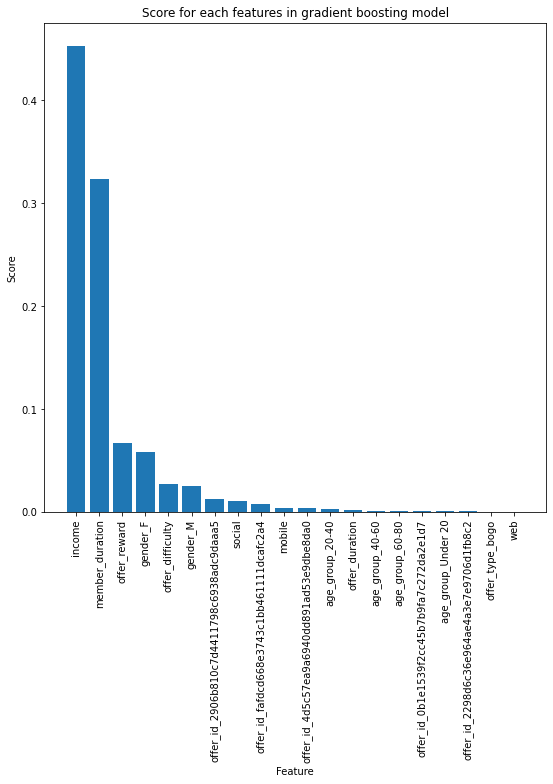

In [77]:
# only look at the first 20 features
x = feature_score['feature'][:20]
y = feature_score['score'][:20]
x_pos = np.arange(len(x))

# make a plot 

plt.figure(figsize = (9,9))
plt.bar(x, y)
plt.xlabel("Feature")
plt.ylabel("Score")
plt.title("Score for each features in gradient boosting model")
plt.xticks(x_pos, x, rotation='vertical')

# plt.show()

plt.savefig("figs/feature_score.png")

Based on the above plot, it shows that income of a customer, the duration of membership, how much award the offer offers and the gender of a customer all play an important role in determining whether a customer will likely fulfill a received offer. 

Also, based on previous data analysis, it shows customers with the follwing characteristics may tend to complete an offer once received:
- with a high income (>105000)
- age 60-80
- female
- offer is discount